In [1]:
#hack till I make it a real package..
import os

#using GPU, comment out if on CPU?
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import jax 
jax.config.update('jax_disable_jit', False)
jax.config.update("jax_debug_nans", True)

In [2]:
import diffhydro as dh
from diffhydro.utils.io import athinput,athdf
from diffhydro.prob_gen import make_gaussian_blob


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/ben.horowitz/miniconda3/envs/jax-cuda12/lib/python3.11/site-packages/IPython/core/magics/pylab.py:166: UserWarning: pylab import has clobbered these variables: ['shape']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


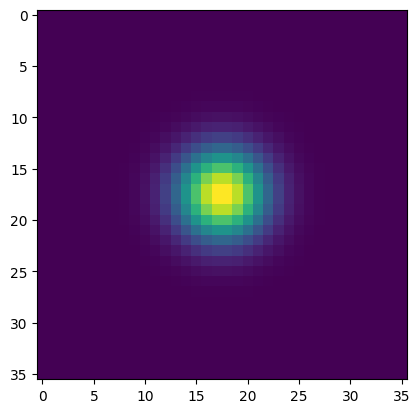

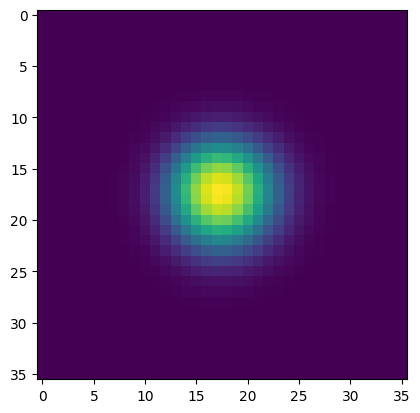

In [4]:
%pylab inline
imshow(init_temp[16])
show()
imshow(final_temp[16])
show()

In [6]:
initial_radius, final_radius

(4.55521678957215, 2.958039891549808)

In [8]:
shape = (64, 64, 64)
eq = dh.equationmanager.EquationManager()

In [17]:
shape = (64, 64, 64)
eq = dh.equationmanager.EquationManager()
eq.cfl=0.1
eq.mesh_shape = list(shape)
eq.thermal_conductivity_model = "SUTHERLAND"
#eq.thermal_conductivity_model = "ELBADRY"
eq._set_transport_properties(None)
#   eq.thermal_conductivity_fun = lambda T: jnp.ones_like(T) * 5.0

init_sol,_ = make_gaussian_blob(eq, shape)

print(init_sol.shape)
conductive_flux = dh.ConductiveFlux(eq, None, None)#,zeta= 5.111496271545331e-12)

hydrosim = dh.hydro(
    n_super_step=100,
    fluxes=[conductive_flux],
    forces=[],
    use_mol=False,
    maxjit=False,
)

state = hydrosim.evolve(init_sol, {})
final_sol = state[0]


(5, 64, 64, 64)
using CTU? False
dt [Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>]
using CTU? False
using CTU? False


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/ben.horowitz/miniconda3/envs/jax-cuda12/lib/python3.11/site-packages/IPython/core/magics/pylab.py:166: UserWarning: pylab import has clobbered these variables: ['shape']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


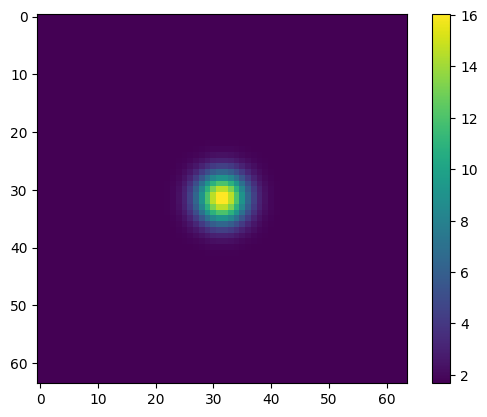

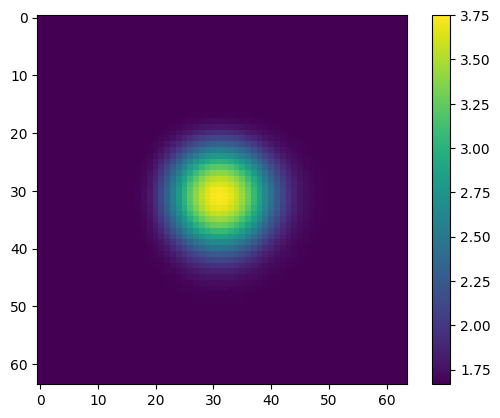

In [18]:
%pylab inline
plt.imshow(init_sol[-1][32])
colorbar()
plt.show()
plt.imshow(final_sol[-1][32])
colorbar()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


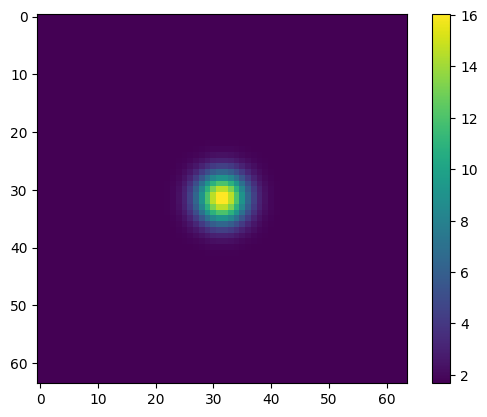

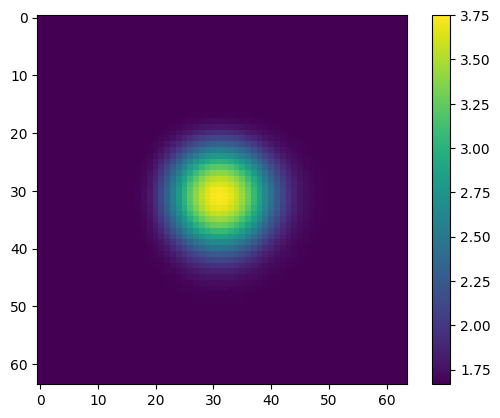

In [19]:
%pylab inline
plt.imshow(init_sol[-1][32])
colorbar()
plt.show()
plt.imshow(final_sol[-1][32])
colorbar()


In [7]:
#stable after 10k iterations? I'll claim success if I figure out how to get the timesteps out of the code nicely...

In [21]:
from diffhydro.utils.diagnostics import blob_radius, isotropy_score

shape = (36, 36, 36)
eq = dh.equationmanager.EquationManager()
eq.mesh_shape = list(shape)
eq.thermal_conductivity_model = "SUTHERLAND"
eq._set_transport_properties(None)
#   eq.thermal_conductivity_fun = lambda T: jnp.ones_like(T) * 5.0

init_sol, init_temperature = make_gaussian_blob(eq, shape)

conductive_flux = dh.ConductiveFlux(eq, None, None)

hydrosim = dh.hydro(
    n_super_step=120,
    fluxes=[conductive_flux],
#    splitting_schemes=[[1, 2, 3]],
    maxjit=False,
)

state = hydrosim.evolve(init_sol, {})
final_sol = state[0]

init_primitives = eq.get_primitives_from_conservatives(init_sol)
final_primitives = eq.get_primitives_from_conservatives(final_sol)

init_temp = eq.get_temperature(
    init_primitives[eq.energy_ids], init_primitives[eq.mass_ids]
)
final_temp = eq.get_temperature(
    final_primitives[eq.energy_ids], final_primitives[eq.mass_ids]
)

initial_radius = blob_radius(np.asarray(init_temp), background=1.0)
final_radius = blob_radius(np.asarray(final_temp), background=1.0)


using CTU? False
dt [Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>, 10000000000.0]
using CTU? False
using CTU? False


In [23]:
final_radius, initial_radius

(9.937303457175895, 4.55521678957215)

In [22]:
assert final_radius > 1.5 * initial_radius

mid_plane = np.asarray(final_temp[:, :, shape[2] // 2])
iso = isotropy_score(mid_plane)
assert iso < 0.1, f"Solution not sufficiently isotropic: std/mean={iso:.3f}"

In [8]:

hydrosim = dh.hydro(
    n_super_step=20000,
    fluxes=[cf],
    forces=[grav],
#    splitting_schemes=[[1, 2, 3]],
    use_mol=True,
    maxjit=False,
)

state = hydrosim.evolve(init_sol, {})
final_sol = state[0]


NameError: name 'cf' is not defined

In [ ]:
%pylab inline
plt.imshow(init_sol[-1][32])
colorbar()
plt.show()
plt.imshow(final_sol[-1][32])
colorbar()


# 